# Mean of Means

Script to calculate the mean of means for motion data from MR-Linac  
This is then used for RT margins calculations  

$$RMS = \sqrt{\frac{1}{n}\sum_ix^2_i}$$

## Sections
1. Importing and defining functions
2. Declaring folder names and parameters
3. Running scripts

## Section 1:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv
import statistics
import math
import numpy as np
from pathlib import Path
import re

In [2]:
## TODO: move this into another script to import for clean code 
# similar to max_min but this being the cleaner one
# need to adapt slightly for max_min

def splitter_base_comparison(original_df, roi):
    """Splits the original csv into two dataframes - base scan and comparison scan for ROI.
    
    Arguments:
    original_df = full original csv in pandas dataFrame
    roi = string of region of interest, ie. "Bladder"
    
    Outputs: 
    comparison_scan = comparison week scan in pandas dataFrame for ROI
    df_base = base week scan data in pandas dataFrame for ROI
    """
    
    # pull out comparison week data from original df
    # get "comparison week' value from unique exam values
    exam_unique_values = original_df.exam.unique()
    
    # perform regex on exam values and use max to return higher week value
    comparison_week = (max(re.search(r'(Wk.)', exam_unique_values[0]).group(0), 
                           re.search(r'(Wk.)', exam_unique_values[-1]).group(0)))
    
    # if case of intrafraction, same week: then take 2nd scan
    if comparison_week == re.search(r'(Wk.)', exam_unique_values[0]).group(0):
        comparison_df = original_df.loc[original_df['exam'] == exam_unique_values[-1]]
    else:
    # check for exam columns that contain comparison week and keep those rows    
        comparison_df = original_df.loc[original_df['exam'].str.contains(comparison_week)]
    
    # then filter df by roi
    comparison_df = comparison_df[comparison_df['roi'].str.contains(roi)]

    # get base week df based on ROI, and remove comparison week
    df_base = original_df[original_df['roi'].str.match(roi)]
    df_base = df_base[df_base['R.x'].eq(0)] if ('R.x' in df_base) else df_base[df_base['S.z'].eq(0)]
    # nb. not the most failsafe method for exception handling!
    
    return df_base, comparison_df


def calculate_means_sd(df, roi, direction):
    
    # run splitter to separate out comparison week data and base week data into two dataframes 
    df_base, df_compare = splitter_base_comparison(df, roi)
    
    # since only comparison week has motion values, calculate mean and sd for those
    mean = df_compare[direction].mean()
    sd = df_compare[direction].std()
        
    return df_base, df_compare, mean, sd

In [3]:
# main function
def output_means(dir_list, roi, direction):
    output_file_paths = [] # init output_paths
    output_boxmean_paths = []
    output_boxsd_paths = []
    
    print("Computing for ROI: {}".format(roi))
    
    for folder in dir_list:
        output = []
        sigma = []
        
        # this part collects means from each patient into a string for calculation of mean of means later
        for filename in os.listdir(folder) :
                        
            if direction in ['R.x', 'L.x', 'A.y', 'P.y'] and filename.endswith('.csv') and filename.startswith('Z') and ("SUPINF" not in filename):
                df = pd.read_csv(os.path.join(folder, filename))

                df_base, df_compare, mean, sd = calculate_means_sd(df, roi, direction)
                
                output.append(mean)
                sigma.append(sd)
                
            
            elif direction in ['S.z', 'I.z'] and filename.endswith('.csv') and filename.startswith('Z') and ("SUPINF" in filename):
                df = pd.read_csv(os.path.join(folder, filename))
                
                df_base, df_compare, mean, sd = calculate_means_sd(df, roi, direction)
                
                output.append(mean)
                sigma.append(sd)
  
        # start of new folder indent
        # calculation of mean of means and, rmse
        mean_of_means = statistics.mean(output)
        sd_means_per_patient = statistics.stdev(output)
        root_mean_square = math.sqrt(statistics.mean([n**2 for n in sigma]))
        mean_of_means = [direction, roi, mean_of_means, sd_means_per_patient, root_mean_square]
        
        # get outputs for boxplots
        # why insert again? 
        sigma.insert(0, roi)
        sigma.insert(0, direction)

        output.insert(0, roi)
        output.insert(0, direction)
        
        #output means of means to csv
        os.makedirs(os.path.join(folder, 'output'), exist_ok=True)
        with open(os.path.join(folder, 'output/meanofmeans_{}.csv'.format(os.path.basename(folder))), 'a') as file_:
            output_file_paths.append(os.path.realpath(file_.name))
            wr = csv.writer(file_, delimiter=',')
            wr.writerow(mean_of_means)
            
        os.makedirs(os.path.join(folder, 'output'), exist_ok=True)
        with open(os.path.join(folder, 'output/boxplot_mean_data_{}.csv'.format(os.path.basename(folder))), 'a') as file_:
            output_boxmean_paths.append(os.path.realpath(file_.name))
            wr = csv.writer(file_, delimiter=',')
            wr.writerow(output)
            
        os.makedirs(os.path.join(folder, 'output'), exist_ok=True)
        with open(os.path.join(folder, 'output/boxplot_sd_data_{}.csv'.format(os.path.basename(folder))), 'a') as file_:
            output_boxsd_paths.append(os.path.realpath(file_.name))
            wr = csv.writer(file_, delimiter=',')
            wr.writerow(sigma)
    
    return list(set(output_file_paths)), list(set(output_boxmean_paths)), list(set(output_boxsd_paths))

In [4]:
## TODO: move this to another separate script too

def write_headers(headers, output_file_paths):
    
    # get output file paths and to add headers to output files
    for file_path in output_file_paths:
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        add_header = pd.read_csv(file_path, names=headers, index_col=None)
        add_header.to_csv(file_path)
        print('Done header:' + file_path)
        

In [5]:
def save_boxplot(file, statistic):

    print(file)
    means_boxplot = pd.read_csv(file, header = None)
    
    headers = ['direction', 'volume' ]
    headers.extend(range(2, means_boxplot.shape[1]))
    means_boxplot.columns = headers
    
    means_boxplot = means_boxplot[~means_boxplot.volume.str.contains("GTV")]
    means = means_boxplot.melt(id_vars=['direction', 'volume'], var_name='scan_num', value_name='distance')
    
    plt.figure(figsize=(15,9.27))
    sns.boxplot(x='direction', y='distance', hue='volume',
            data= means, 
            whis=[5,95],
            meanprops={"marker": None,"markerfacecolor":"black", "markeredgecolor":"black", "color":"black", "linestyle":"solid"},
            medianprops={"linewidth":0},
            meanline=True, showmeans=True,
            showfliers=False).set_title('Patient {} displacement {}'.format(statistic, os.path.basename(Path(file).resolve().parents[1])))
    sns.despine()
    plt.tick_params(bottom=False)
    
    plt.savefig(os.path.join(Path(file).resolve().parents[1], 'output/{}{}.png'.format(statistic, os.path.basename(Path(file).resolve().parents[1]))))
    
    return plt, means

## Part 2 : Specify folders and params

In [6]:
folder_name = [
    'Dec20_data/Interfraction/Interfraction 3D 0.8', 
    'Dec20_data/Interfraction/Interfraction DIXON 2.0', 
    'Dec20_data/Intrafraction 3D vs DIXON HR IP 2.0'
    ]

dir_list = []
for i in range(len(folder_name)):
    dir_list.append(
        os.path.join(os.getcwd(), folder_name[i])
    )

roi_list = ['CTV_Clin', 'CTV_SmallVol', 'GTV_T']
direction_list = ['R.x', 'L.x', 'A.y', 'P.y', 'S.z', 'I.z']

## Part 3 : Run Scripts

Computing for ROI: CTV_Clin
Computing for ROI: CTV_Clin
Computing for ROI: CTV_Clin
Computing for ROI: CTV_Clin
Computing for ROI: CTV_Clin
Computing for ROI: CTV_Clin
Computing for ROI: CTV_SmallVol
Computing for ROI: CTV_SmallVol
Computing for ROI: CTV_SmallVol
Computing for ROI: CTV_SmallVol
Computing for ROI: CTV_SmallVol
Computing for ROI: CTV_SmallVol
Computing for ROI: GTV_T
Computing for ROI: GTV_T
Computing for ROI: GTV_T
Computing for ROI: GTV_T
Computing for ROI: GTV_T
Computing for ROI: GTV_T
Done header:/mnt/3602F83B02F80223/MR Linac/Dec20_data/Interfraction/Interfraction 3D 0.8/output/meanofmeans_Interfraction 3D 0.8.csv
Done header:/mnt/3602F83B02F80223/MR Linac/Dec20_data/Interfraction/Interfraction DIXON 2.0/output/meanofmeans_Interfraction DIXON 2.0.csv
Done header:/mnt/3602F83B02F80223/MR Linac/Dec20_data/Intrafraction 3D vs DIXON HR IP 2.0/output/meanofmeans_Intrafraction 3D vs DIXON HR IP 2.0.csv
/mnt/3602F83B02F80223/MR Linac/Dec20_data/Intrafraction 3D vs DIXON H

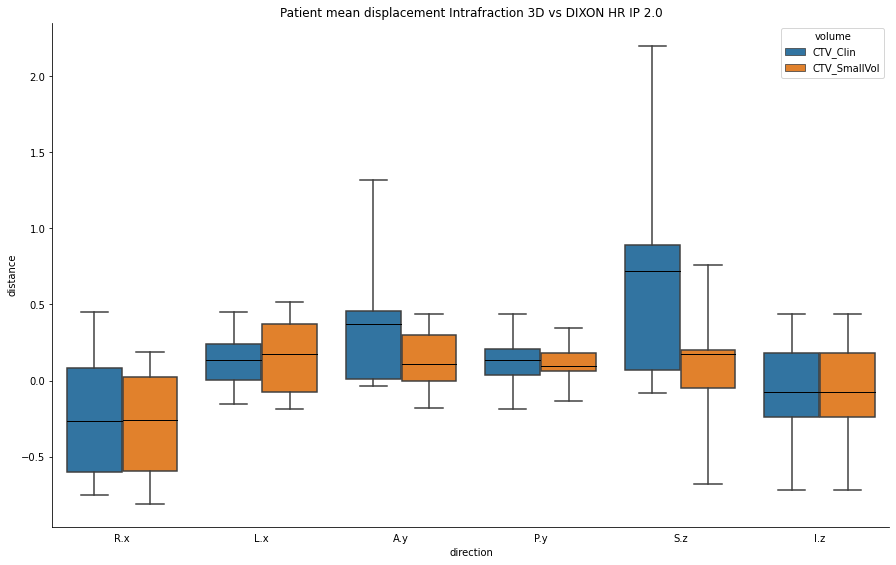

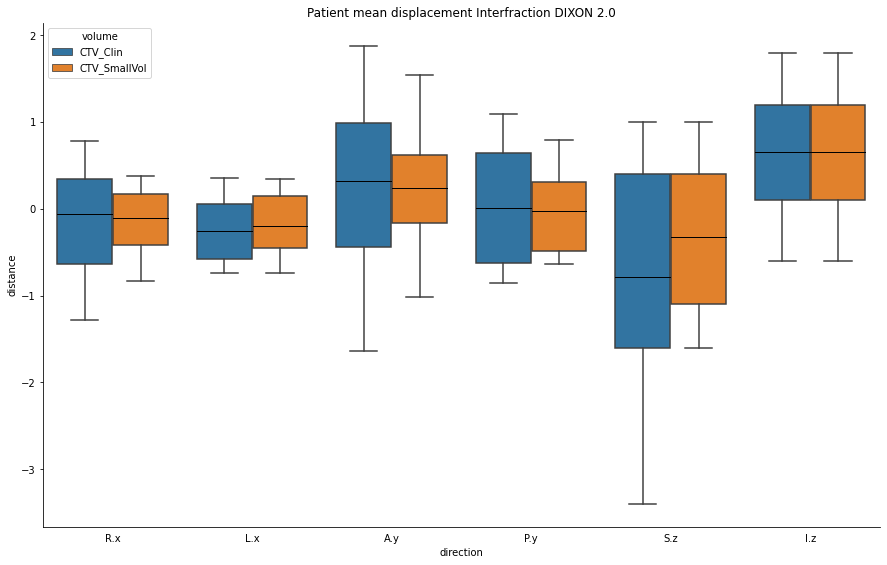

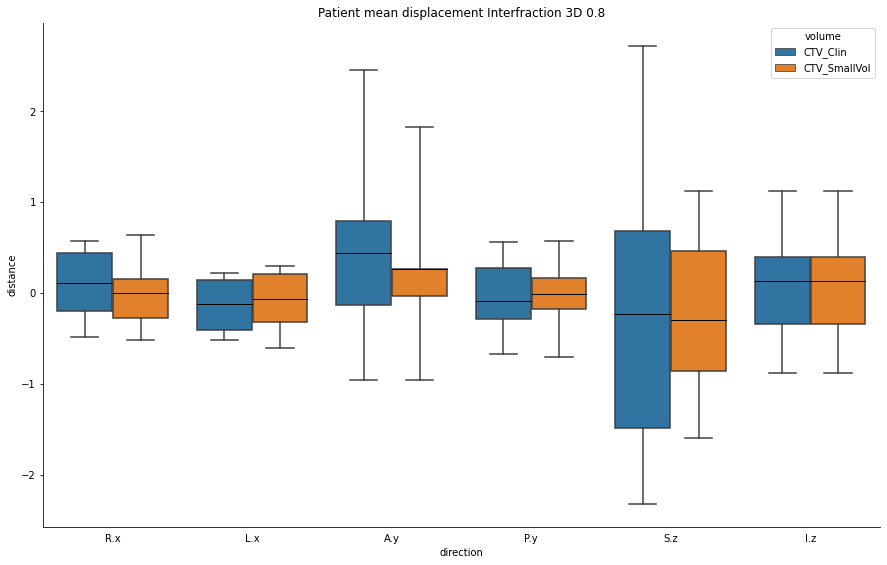

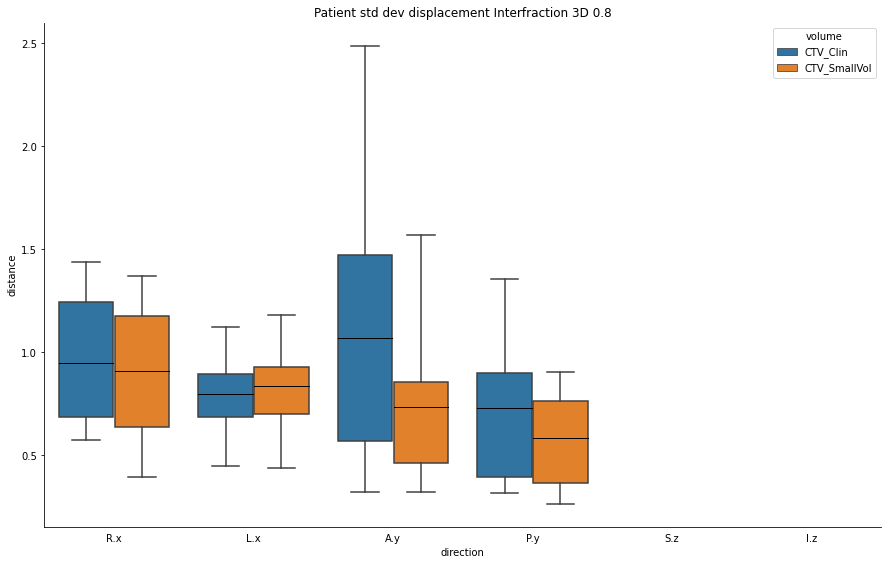

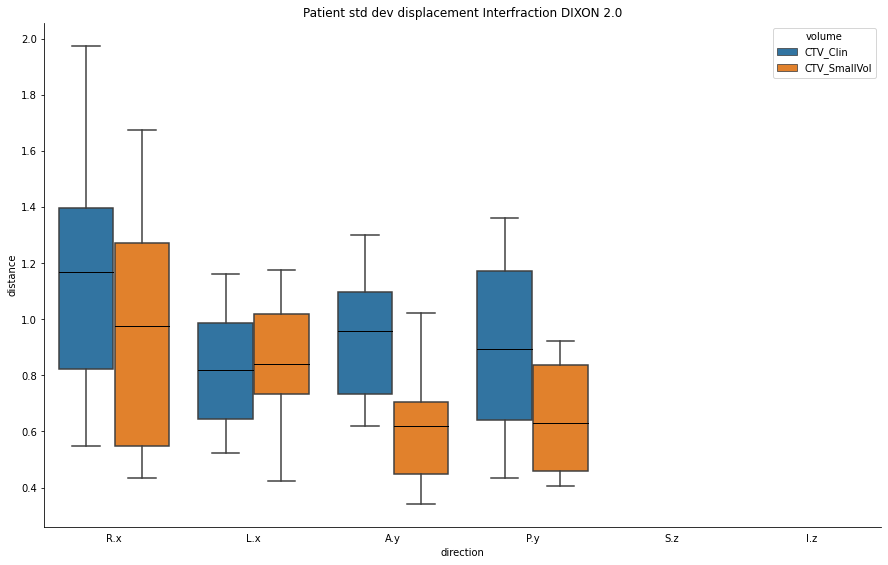

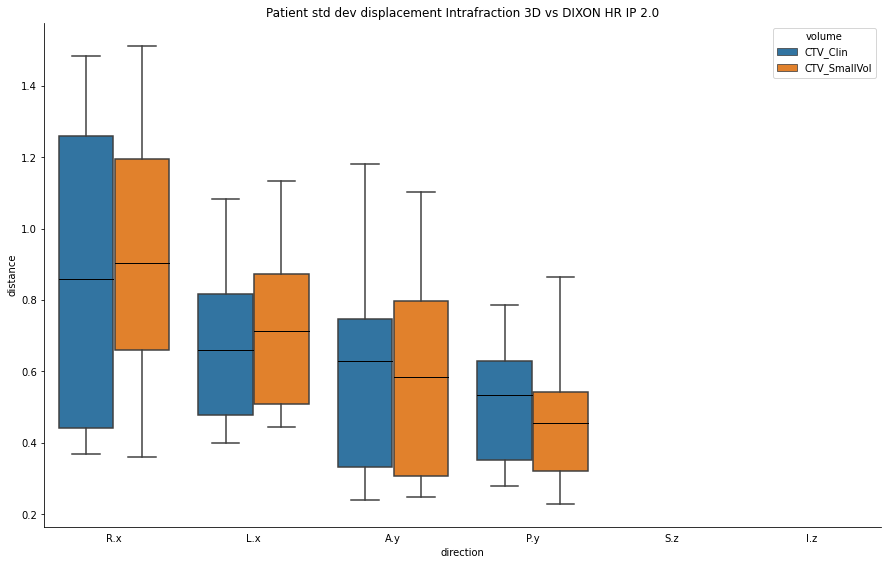

In [7]:
# execute all functions
# 1. do all calculations 
for roi in roi_list:
    for direction in direction_list:
        output_file_paths, output_boxmean_paths, output_boxsd_paths = output_means(dir_list, roi, direction)

# 2. write all headers'
headers_meansofmeans = ['direction', 'volume', 'mean of means', 'E', 'sigma']
write_headers(headers_meansofmeans, output_file_paths)

# 3. draw all boxplots
for file in output_boxmean_paths:
    save_boxplot(file, 'mean')
    
for file in output_boxsd_paths:
    save_boxplot(file, 'std dev')
    